## Solow Growth Model

The Solow Growth Model, developed by Robert Solow in the 1950s, is a cornerstone of theoretical economics, providing insights into the determinants of economic growth and the role of capital accumulation, labor force, and technological progress.

### The Basic Model

The Solow model posits that the output of an economy (Y) depends on the amounts of capital (K) and labor (L), along with a constant representing the level of technology (A). The model is often expressed with a production function that has constant returns to scale, typically a Cobb-Douglas production function:

$$ Y = A K^\alpha L^{1-\alpha} $$

where:
- \( Y \) is the total output (or real GDP) of the economy.
- \( A \) is a factor productivity term representing technology.
- \( K \) is the total amount of physical capital in the economy.
- \( L \) is the total labor force.
- \( \alpha \) (0 < α < 1) is the output elasticity of capital, indicating the percentage increase in output resulting from a percentage increase in capital, holding labor constant.

### Simplified Assumptions

To simplify the analysis, the Solow model often assumes that labor grows at a constant exogenous rate and that savings and investment are a fixed proportion of output. The model shows how these investments affect the capital stock over time, leading to economic growth through capital accumulation. The model also explores the concept of steady-state equilibrium, where the capital stock remains constant over time when depreciation and capital formation are balanced.

### Implications

One of the key insights from the Solow model is that higher savings rates can lead to a higher level of steady-state capital and output, but not to a higher growth rate in the long run. The long-term growth rate is determined by technological progress, according to the Solow model.

The model highlights the importance of technological advances and productivity improvements in sustaining long-term economic growth, beyond just the accumulation of capital and labor inputs.


## Hyman Minsky's Financial Instability Hypothesis and Minsky Moments

Hyman Minsky, an American economist, developed the Financial Instability Hypothesis (FIH), which emphasizes the dynamics of financial markets and their role in shaping economic cycles. His theory proposes that financial systems inherently tend toward periods of boom and bust due to the cyclical fluctuations in investor behavior and economic stability.

### Financial Instability Hypothesis

Minsky's model is built on the observation that during prosperous times, firms and consumers alike tend to increase their debt, becoming progressively riskier in their financial behaviors. This leads to what Minsky identified as three types of borrowers:
- **Hedge Borrowers:** Can pay back both the interest and principal from their cash flows.
- **Speculative Borrowers:** Can cover the interest but must continually roll over the principal.
- **Ponzi Borrowers:** Cannot cover the interest or principal from their operations and must borrow further or sell assets to meet their obligations.

As the economy grows, the proportion of speculative and Ponzi borrowers increases, elevating the financial risk within the system.

### Minsky Moments

A "Minsky Moment" is a sudden market collapse that follows a long period of bullish growth, typically caused by the unsustainable accumulation of debt by speculative and Ponzi borrowers. When these borrowers fail to meet their debt obligations due to a downturn or tightening credit conditions, it can lead to a rapid deflation of asset prices, increased volatility, and a retrenchment of economic activity.

These moments are characterized by:
- Rapid deleveraging
- Falling asset prices
- Abrupt slowdowns in economic activity

### Implications

The FIH and the concept of Minsky Moments have become particularly relevant in discussions of economic policy and regulation, especially following the global financial crisis of 2007-2008, which many analysts consider a quintessential Minsky Moment. Minsky's work suggests that to prevent such crises, regulatory measures should focus on curtailing excessive debt accumulation and managing the cyclical expansions of financial behavior.

Minsky's insights challenge the traditional views of financial markets always moving toward equilibrium, emphasizing instead the potential for sudden and severe economic instability due to internal market dynamics.


## Data Acquisition and Preprocessing Overview

This project involves analyzing economic and financial data to detect potential asset price bubbles. The data sources include GDP and job openings from governmental sources like the Federal Reserve Economic Data (FRED) and the Bureau of Labor Statistics (BLS), as well as stock market indices from various global markets.

### File Paths and Initial Data Loading

- **File Paths:** The project's data files are stored in a structured directory. The paths are set relative to a base path defined at the beginning of the script.
- **Loading Data:** The GDP and country keys data are loaded into pandas dataframes from CSV files. The GDP data includes multiple series, which are filtered based on a selected country.

### Specific Column Selection

- **Country and Series Identification:** A specific country, in this case, the United States, is selected, and corresponding series IDs for GDP and the stock index are extracted from the country keys data.
- **Data Filtering:** The main dataframe is filtered to include only the relevant GDP series and the 'USJO' column, which represents job openings data sourced from the BLS.

### Data Cleaning

- **Handling Missing Values:** The dataframe is cleaned by dropping any rows with missing values to ensure the integrity of the analyses.
- **Date Conversion:** The 'DATE' column is converted to datetime format, which facilitates time-series analysis and merging operations with other time-based data sources.

### Function for Data Selection

- **`get_observations_before_date_v3`:** This function extracts a specific number of observations from the dataframe before a given date. It ensures that the data is sorted and that only the relevant observations are returned, which is crucial for time-sensitive financial analyses.

### Stock Market Data Acquisition

- **Stock Index Data:** Stock data for the selected country’s primary index is downloaded using the `yfinance` library, which provides access to historical market data. The data is resampled to a quarterly frequency to match the GDP and job openings data.

### Data Merging

- **As-Of Merge:** The economic data (GDP and job openings) is merged with the stock market data using a backward as-of merge. This method aligns each stock market observation with the latest available economic data observation as of each date in the stock data.

### Data Alignment and Preparation for Analysis

- **Trimming and Alignment:** The length of the arrays containing calculated statistics (like GSADF statistics) is adjusted to match the length of the merged dataframe. This involves either trimming excess data or padding with NaNs to account for missing periods.
- **Final Merging:** The adjusted GSADF statistics are added to the merged dataframe, creating a comprehensive dataset ready for further analysis.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
import os

import mplcyberpunk
plt.style.use("cyberpunk")
# python 3.9.12 for cyberpunk plot style 

In [2]:
# Define file paths

path = '/Users/philiplacava/Desktop/'

gdp = 'Asset-Price-Bubble-Detection/GDP Data/Series_List.csv'

df = pd.read_csv(path + gdp)
countries = pd.read_csv('/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/Country Keys.csv')

# Correctly select specific columns
country = countries[['Country', 'GDP_SeriesID', 'Stock_index']]
# Example: Selecting the GDP_SeriesID for the USA
select = 'United States'

gdp_series_id = country.loc[country['Country'] == select, 'GDP_SeriesID'].values[0]
title = country.loc[country['Country'] == select, 'Country'].values[0]

# Assuming 'df' contains columns like 'DATE' and many GDP series
df = df[['DATE', gdp_series_id, 'USE' , 'USJO', 'USU', 'USP']]#, 'USJO' ,'USU']]  # Selecting DATE and the specific GDP series column
df = df.rename(columns={gdp_series_id: 'GDP'})  # Rename the GDP series column

# Clean up data
df = df.dropna()

print(df)


        DATE        GDP          USE    USJO     USU       USP
204   1/1/01  3545780.0  137088.0000  4752.0  5603.0  284169.0
205   4/1/01  3567923.5  136719.3333  4125.0  6084.0  284838.0
206   7/1/01  3553629.0  136225.6667  3937.0  6327.0  285584.0
207  10/1/01  3563393.5  136105.3333  3249.0  6922.0  286311.0
208   1/1/02  3593196.3  136360.0000  3289.0  7985.0  286935.0
..       ...        ...          ...     ...     ...       ...
291  10/1/22  5497495.3  160425.6667  9538.0  5841.0  334201.0
292   1/1/23  5528082.3  160891.0000  9348.0  5868.0  334547.0
293   4/1/23  5556337.5  161419.6667  8864.0  5849.0  334934.0
294   7/1/23  5622673.0  161443.0000  7820.0  5943.0  335430.0
295  10/1/23  5668214.8  161195.3333  7718.0  6197.0  335923.0

[92 rows x 6 columns]


In [3]:
def get_observations_before_date_v3(df, date_column, date_str, num_observations):
    """
    Extracts a specified number of observations from a DataFrame immediately before a given date using a date column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column that contains the date values.
        date_str (str): The target date in 'YYYY-MM-DD' format.
        num_observations (int): The number of observations to retrieve before the date.

    Returns:
        pd.DataFrame: A subset of the original DataFrame with the specified number of observations before the date.
    """
    # Convert the date column to datetime if not already
    df[date_column] = pd.to_datetime(df[date_column])

    # Sort the DataFrame by the date column to ensure chronological order
    df.sort_values(by=date_column, inplace=True)

    # Filter the DataFrame to only include rows before the target date
    before_date_df = df[df[date_column] < pd.to_datetime(date_str)]

    # Select the last 'num_observations' entries from this filtered DataFrame
    if len(before_date_df) > num_observations:
        df_subset = before_date_df.iloc[-num_observations:]
    else:
        df_subset = before_date_df  # In case there are fewer rows than 'num_observations'

    return df_subset
cut_date = '2016-10-31'
subset_df = get_observations_before_date_v3(df, 'DATE', cut_date, 295)

#df = subset_df

df 

,DATE,GDP,USE,USJO,USU,USP
204,2001-01-01,3545780.0,137088.0000,4752.0,5603.0,284169.0
205,2001-04-01,3567923.5,136719.3333,4125.0,6084.0,284838.0
206,2001-07-01,3553629.0,136225.6667,3937.0,6327.0,285584.0
207,2001-10-01,3563393.5,136105.3333,3249.0,6922.0,286311.0
208,2002-01-01,3593196.3,136360.0000,3289.0,7985.0,286935.0
...,...,...,...,...,...,...
291,2022-10-01,5497495.3,160425.6667,9538.0,5841.0,334201.0
292,2023-01-01,5528082.3,160891.0000,9348.0,5868.0,334547.0
293,2023-04-01,5556337.5,161419.6667,8864.0,5849.0,334934.0
294,2023-07-01,5622673.0,161443.0000,7820.0,5943.0,335430.0


First, pick a stock you would like to forcast from yahoo finance. For the purposes of demonstration we will use quarterly data of the DJIA 

In [4]:
# Read stock data from yfinance 
# ^IXIC Nasdaq
# ^GSPC S&P
# ^DJA Dow
# Brazil Index ^BVSP
# India Index  ^BSESN
# Germany ^GDAXI
# Japan ^N225
# Mexico ^MXX
ticker = country.loc[country['Country'] == select, 'Stock_index'].values[0]
start = '1980-01-01'
end = df['DATE'].iloc[-1]
data = yf.download(ticker, start, end, interval='3mo')['Close']
T = len(data)
data_df = data.reset_index()
data_df.rename(columns={'Close': 'Price'}, inplace=True)

data_df

[*********************100%%**********************]  1 of 1 completed


,Date,Price
0,1984-12-01,523.469971
1,1985-03-01,541.570007
2,1985-06-01,554.369995
3,1985-09-01,589.219971
4,1985-12-01,679.609985
...,...,...
151,2022-09-01,11536.080078
152,2022-12-01,11048.129883
153,2023-03-01,10872.000000
154,2023-06-01,11610.440430


In [5]:
merged_df = pd.merge_asof(df.sort_values('DATE'), 
                          data_df.sort_values('Date'), 
                          left_on='DATE', 
                          right_on='Date', 
                          direction='backward')
merged_df = merged_df.dropna()
merged_df

,DATE,GDP,USE,USJO,USU,USP,Date,Price
0,2001-01-01,3545780.0,137088.0000,4752.0,5603.0,284169.0,2000-12-01,3211.179932
1,2001-04-01,3567923.5,136719.3333,4125.0,6084.0,284838.0,2001-03-01,3302.189941
2,2001-07-01,3553629.0,136225.6667,3937.0,6327.0,285584.0,2001-06-01,3009.209961
3,2001-10-01,3563393.5,136105.3333,3249.0,6922.0,286311.0,2001-09-01,2807.510010
4,2002-01-01,3593196.3,136360.0000,3289.0,7985.0,286935.0,2001-12-01,2918.530029
...,...,...,...,...,...,...,...,...
87,2022-10-01,5497495.3,160425.6667,9538.0,5841.0,334201.0,2022-09-01,11536.080078
88,2023-01-01,5528082.3,160891.0000,9348.0,5868.0,334547.0,2022-12-01,11048.129883
89,2023-04-01,5556337.5,161419.6667,8864.0,5849.0,334934.0,2023-03-01,10872.000000
90,2023-07-01,5622673.0,161443.0000,7820.0,5943.0,335430.0,2023-06-01,11610.440430


In [6]:
price = data_df['Price']
price 
T = len(price)

## Overview of Explosive Unit Root Analysis Using SADF and GSADF Tests

The provided Python code implements the SADF and GSADF tests to detect explosive behavior (unit roots) in time series data. These tests are useful for identifying speculative bubbles or other forms of non-stationarity within economic data, which might indicate periods of excessive price increases followed by abrupt corrections.

### Initial Settings

- **`r0`**: The initial proportion of the sample used for the minimum window size for the rolling tests. It is set based on a formula that adjusts with the square root of the sample size `T`.
- **`swindow0`**: The actual size of the initial window converted from the proportion `r0`.
- **`dim`**: The number of test statistics that will be calculated, based on the total sample size `T` minus the size of the initial window `swindow0`.
- **`date`**: An array of dates that correspond to the length of the data, assuming quarterly frequency starting from the first index of the merged dataset.

### Functions

- **`simulate_critical_values(num_simulations, T, r0)`**: This function simulates critical values for the SADF/GSADF tests. It does so by repeatedly generating a unit root process and calculating the ADF statistic for each simulation. The critical values for the 90%, 95%, and 99% confidence levels are then derived from these simulated statistics.

### Calculation of SADF and GSADF Statistics

- **SADF Calculation**:
  - The SADF statistic is computed using a rolling window approach where the ADF test is applied to expanding windows of data starting from the initial window size to the end of the series.
  - The maximum ADF statistic from these windows is taken as the SADF statistic, indicating the strongest evidence of a unit root within any window.

- **GSADF Calculation**:
  - Similar to the SADF, but the GSADF allows for both starting and ending points of the window to vary.
  - This test computes the ADF statistic for every possible window combination within the dataset, starting from the initial window size.
  - The maximum of these statistics is the GSADF statistic, providing a more flexible test that can detect multiple periods of explosive behavior.

### Output

- The code outputs the calculated SADF and GSADF statistics and compares them against the critical values derived from the simulations. It also prints the length of the GSADF statistics array and the corresponding dates, which helps in identifying the specific time periods of potential explosive behavior.

### Usage

- The code is set up to analyze a series (likely stock prices or similar financial data) stored in the variable `price`.
- Users can adjust the number of simulations and the sample size `T` as needed based on their specific dataset and the desired accuracy of the test results.


In [7]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1
date = pd.date_range(start= merged_df.index[0], periods=T, freq='Q-DEC')

def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        # Placeholder for SADF/GSADF calculation: this should ideally be replaced
        # with a function that calculates the SADF/GSADF statistic.
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


Critical values at 90%, 95%, 99%: [0.00287385 0.47572082 1.36174212]


In [8]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(price[:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)

The SADF statistic: 2.7099602824049502


In [9]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(price[r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)
bsadfs = bsadfs[:-1]
len(bsadfs),len(dateS)


The GSADF statistic: 3.627281027065263
The critical values: [0.00287385 0.47572082 1.36174212]


(132, 132)

In [10]:
# Assuming bsadfs, merged_df, and other necessary variables are already defined
# Print current lengths to understand the situation
print("Length of dateS:", len(dateS))
print("Length of bsadfs before trimming:", len(bsadfs))
print("Length of badfs:", len(badfs))

# Trim bsadfs if it's longer than merged_df
if len(bsadfs) > len(merged_df):
    bsadfs = bsadfs[-len(merged_df):]  # Trim from the beginning to match the end
elif len(bsadfs) < len(merged_df):
    # Calculate the number of missing periods
    missing_periods = len(merged_df) - len(bsadfs)
    # Create an array of NaNs for the missing periods
    initial_nans = np.full(missing_periods, np.nan)
    # Concatenate the NaNs with the bsadfs array to align with the end of merged_df
    bsadfs = np.concatenate((initial_nans, bsadfs))

# Add the bsadfs array to the DataFrame
merged_df['GSADF_Stat'] = bsadfs

# Optional: Drop rows with NaNs in the 'GSADF_Stat' if needed
merged_df = merged_df.dropna(subset=['GSADF_Stat'])
print(merged_df)


Length of dateS: 132
Length of bsadfs before trimming: 132
Length of badfs: 133
         DATE        GDP          USE    USJO     USU       USP       Date  \
0  2001-01-01  3545780.0  137088.0000  4752.0  5603.0  284169.0 2000-12-01   
1  2001-04-01  3567923.5  136719.3333  4125.0  6084.0  284838.0 2001-03-01   
2  2001-07-01  3553629.0  136225.6667  3937.0  6327.0  285584.0 2001-06-01   
3  2001-10-01  3563393.5  136105.3333  3249.0  6922.0  286311.0 2001-09-01   
4  2002-01-01  3593196.3  136360.0000  3289.0  7985.0  286935.0 2001-12-01   
..        ...        ...          ...     ...     ...       ...        ...   
87 2022-10-01  5497495.3  160425.6667  9538.0  5841.0  334201.0 2022-09-01   
88 2023-01-01  5528082.3  160891.0000  9348.0  5868.0  334547.0 2022-12-01   
89 2023-04-01  5556337.5  161419.6667  8864.0  5849.0  334934.0 2023-03-01   
90 2023-07-01  5622673.0  161443.0000  7820.0  5943.0  335430.0 2023-06-01   
91 2023-10-01  5668214.8  161195.3333  7718.0  6197.0  335923.

In [11]:
merged_df = merged_df.drop(columns=['Date'])

# Display the DataFrame to verify the column has been removed
print(merged_df)

         DATE        GDP          USE    USJO     USU       USP         Price  \
0  2001-01-01  3545780.0  137088.0000  4752.0  5603.0  284169.0   3211.179932   
1  2001-04-01  3567923.5  136719.3333  4125.0  6084.0  284838.0   3302.189941   
2  2001-07-01  3553629.0  136225.6667  3937.0  6327.0  285584.0   3009.209961   
3  2001-10-01  3563393.5  136105.3333  3249.0  6922.0  286311.0   2807.510010   
4  2002-01-01  3593196.3  136360.0000  3289.0  7985.0  286935.0   2918.530029   
..        ...        ...          ...     ...     ...       ...           ...   
87 2022-10-01  5497495.3  160425.6667  9538.0  5841.0  334201.0  11536.080078   
88 2023-01-01  5528082.3  160891.0000  9348.0  5868.0  334547.0  11048.129883   
89 2023-04-01  5556337.5  161419.6667  8864.0  5849.0  334934.0  10872.000000   
90 2023-07-01  5622673.0  161443.0000  7820.0  5943.0  335430.0  11610.440430   
91 2023-10-01  5668214.8  161195.3333  7718.0  6197.0  335923.0  10812.339844   

    GSADF_Stat  
0     0.91

In [12]:

def add_transformations(df, columns):
    """
    Add log, first difference, and log difference transformations to specified columns.

    Parameters:
    df (DataFrame): The DataFrame to modify.
    columns (list of str): List of column names to transform.

    Returns:
    DataFrame: The modified DataFrame with new columns.
    """
    for col in columns:
        # Calculate log of the column
        df[f'Log_{col}'] = np.log(df[col])

        # Calculate first difference of the column
        df[f'{col}_Diff'] = df[col].diff()

        # Calculate first difference of the log of the column
        df[f'Log_{col}_Diff'] = df[f'Log_{col}'].diff()

    # Drop the initial NaN values resulting from differencing
    df = df.dropna()

    return df

# Define the columns you want to transform
columns_to_transform = ['GDP', 'Price', 'USE', 'USJO', 'USU', 'USP']

# Apply the transformations
merged_df.set_index('DATE', inplace=True)
merged_df = add_transformations(merged_df, columns_to_transform)

# Display the resulting merged DataFrame
merged_df


,GDP,USE,USJO,USU,USP,Price,GSADF_Stat,Log_GDP,GDP_Diff,Log_GDP_Diff,...,Log_USE_Diff,Log_USJO,USJO_Diff,Log_USJO_Diff,Log_USU,USU_Diff,Log_USU_Diff,Log_USP,USP_Diff,Log_USP_Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2001-04-01,3567923.5,136719.3333,4125.0,6084.0,284838.0,3302.189941,0.986011,15.087494,22143.5,0.006226,...,-0.002693,8.324821,-627.0,-0.141500,8.713418,481.0,0.082360,12.559676,669.0,0.002351
2001-07-01,3553629.0,136225.6667,3937.0,6327.0,285584.0,3009.209961,0.328150,15.083480,-14294.5,-0.004014,...,-0.003617,8.278174,-188.0,-0.046647,8.752581,243.0,0.039164,12.562291,746.0,0.002616
2001-10-01,3563393.5,136105.3333,3249.0,6922.0,286311.0,2807.510010,-0.233647,15.086224,9764.5,0.002744,...,-0.000884,8.086103,-688.0,-0.192072,8.842460,595.0,0.089879,12.564834,727.0,0.002542
2002-01-01,3593196.3,136360.0000,3289.0,7985.0,286935.0,2918.530029,-0.153319,15.094553,29802.8,0.008329,...,0.001869,8.098339,40.0,0.012236,8.985320,1063.0,0.142860,12.567011,624.0,0.002177
2002-04-01,3615212.0,136806.6667,3025.0,8234.0,287574.0,2891.060059,-0.229383,15.100661,22015.7,0.006108,...,0.003270,8.014666,-264.0,-0.083672,9.016027,249.0,0.030707,12.569235,639.0,0.002225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,5497495.3,160425.6667,9538.0,5841.0,334201.0,11536.080078,1.833280,15.519803,34711.8,0.006334,...,0.009946,9.163039,-812.0,-0.081703,8.672657,-154.0,-0.026024,12.719498,439.0,0.001314
2023-01-01,5528082.3,160891.0000,9348.0,5868.0,334547.0,11048.129883,1.262708,15.525352,30587.0,0.005548,...,0.002896,9.142918,-190.0,-0.020121,8.677269,27.0,0.004612,12.720533,346.0,0.001035
2023-04-01,5556337.5,161419.6667,8864.0,5849.0,334934.0,10872.000000,1.125399,15.530450,28255.2,0.005098,...,0.003280,9.089753,-484.0,-0.053164,8.674026,-19.0,-0.003243,12.721689,387.0,0.001156


In [13]:
merged_df.to_csv('vecm_data.csv', index=True)  # creating csv of this data


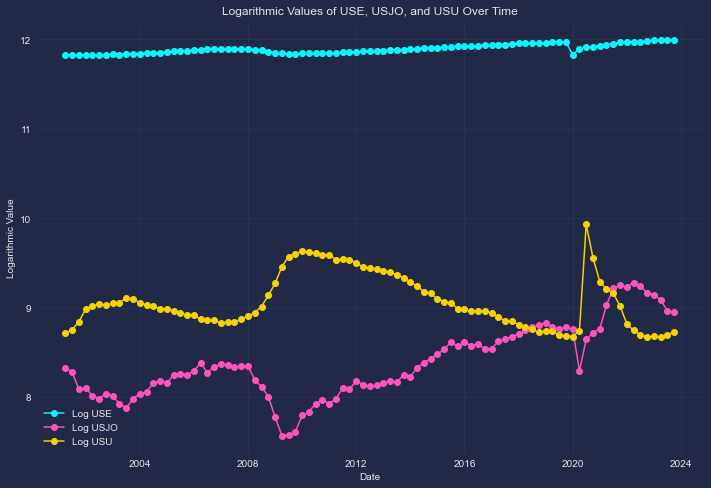

In [14]:
# Plot the logarithmic values
plt.figure(figsize=(12, 8))
plt.plot(merged_df.index, merged_df['Log_USE'], label='Log USE', marker='o')
plt.plot(merged_df.index, merged_df['Log_USJO'], label='Log USJO', marker='o')
plt.plot(merged_df.index, merged_df['Log_USU'], label='Log USU', marker='o')

plt.title('Logarithmic Values of USE, USJO, and USU Over Time')
plt.xlabel('Date')
plt.ylabel('Logarithmic Value')
plt.legend()
plt.grid(True)
plt.show()

## Importance of Checking Cointegration, Seasonality, and Stationarity in VECM Specification

When specifying a Vector Error Correction Model (VECM), it is crucial to assess cointegration, seasonality, and stationarity of the involved time series. These checks are fundamental for ensuring the validity of the model, the accuracy of the inferences drawn from it, and the effectiveness of the model in capturing the underlying economic dynamics.

### 1. Stationarity

- **Definition:** A stationary time series has a constant mean, variance, and autocorrelation structure over time, meaning its statistical properties do not change over time.
- **Importance in VECM:**
  - **Model Stability and Reliability:** Non-stationary data can lead to spurious results in regression-type models, which assume stationary inputs. VECM requires that all series included in the model are integrated of the same order, typically I(1), which means they become stationary after first differencing.
  - **Pre-condition for Cointegration:** Only non-stationary series that are integrated of the same order can be tested for cointegration, a key component in the VECM framework.

### 2. Cointegration

- **Definition:** Cointegration occurs when a linear combination of two or more non-stationary series is itself stationary. This implies a long-term equilibrium relationship among the series despite short-term deviations.
- **Importance in VECM:**
  - **Capturing Long-Term Relationships:** Cointegration indicates that the variables share a common stochastic trend and are bound by an equilibrium relationship, even though they may individually wander away from equilibrium.
  - **Error Correction Term (ECT):** VECM includes an error correction term derived from the cointegration equation, which adjusts the short-term dynamics of the dependent variables to correct for deviations from this long-term equilibrium.

### 3. Seasonality

- **Definition:** Seasonality refers to periodic fluctuations in time series data that occur at regular intervals, such as quarterly, monthly, or yearly.
- **Importance in VECM:**
  - **Model Accuracy:** Ignoring seasonal variations can lead to misinterpretations of trends and cycles in the data. Seasonal adjustments ensure that the model captures true underlying trends rather than seasonal effects.
  - **Improved Forecasting:** Correctly modeling seasonality improves the model's predictive performance, particularly for economic and financial data, which often exhibit strong seasonal patterns.


In [15]:
def perform_adf_test(series, regression_type='ct'):
    """
    Perform an Augmented Dickey-Fuller test on a given time series.

    Parameters:
        series (pd.Series): The time series on which to perform the ADF test.
        regression_type (str): The type of regression ('c' for constant, 'ct' for constant and trend, 'ctt' for constant, and linear and quadratic trend, 'nc' for no constant, no trend).

    Returns:
        None
    """
    result = adfuller(series, regression=regression_type)
    print(f"ADF Statistic for {series.name}: {result[0]}")
    print(f"p-value for {series.name}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[0] < result[4]['10%']:
        print(f"Reject the null hypothesis - the {series.name} series is stationary at the 90% confidence level.")
    else:
        print(f"Fail to reject the null hypothesis - the {series.name} series is not stationary at the 90% confidence level.")


In [16]:
for column in merged_df.columns:
    result = perform_adf_test(merged_df[column], regression_type='ct')
    print(f'ADF Test for {column}:\n{result}\n')

ADF Statistic for GDP: -2.6531120629489897
p-value for GDP: 0.2560615030010873
Critical Values:
	1%: -4.063
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the GDP series is not stationary at the 90% confidence level.
ADF Test for GDP:
None

ADF Statistic for USE: -3.1251730159156543
p-value for USE: 0.10036866652148613
Critical Values:
	1%: -4.063
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the USE series is not stationary at the 90% confidence level.
ADF Test for USE:
None

ADF Statistic for USJO: -1.6391678567313306
p-value for USJO: 0.7767215699077986
Critical Values:
	1%: -4.071
	5%: -3.464
	10%: -3.158
Fail to reject the null hypothesis - the USJO series is not stationary at the 90% confidence level.
ADF Test for USJO:
None

ADF Statistic for USU: -2.933775433235185
p-value for USU: 0.15154640469197445
Critical Values:
	1%: -4.063
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the USU series is not stationary at the 90% confidence le

In [17]:
# Define color variables
color_job_openings = 'cyan'
color_bsadf_stat = 'magenta'
color_stock_index = 'limegreen'
color_gdp = 'yellow'
color_population = 'blue'
color_unemployment = 'red'
axis_color = 'white' 

<Figure size 720x360 with 0 Axes>

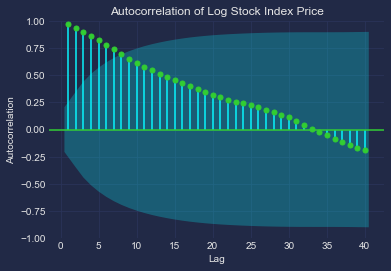

<Figure size 720x360 with 0 Axes>

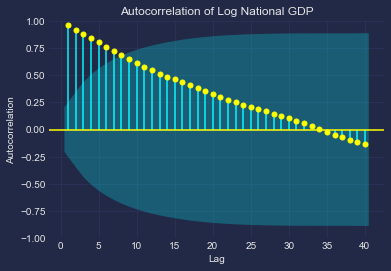

<Figure size 720x360 with 0 Axes>

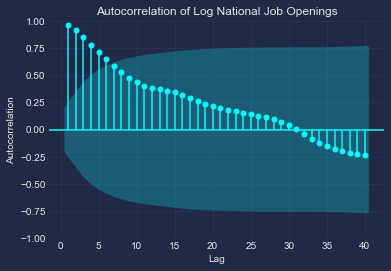

<Figure size 720x360 with 0 Axes>

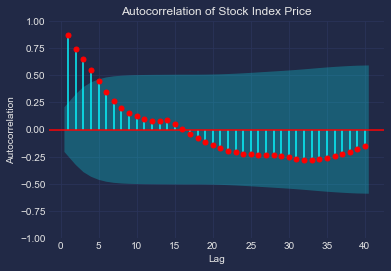

<Figure size 720x360 with 0 Axes>

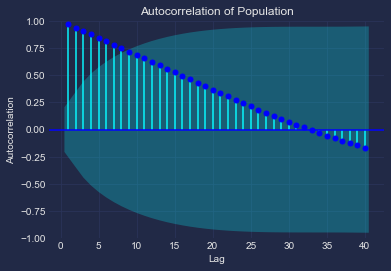

<Figure size 720x360 with 0 Axes>

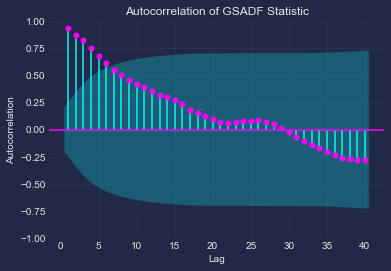

In [18]:
# Plot Correlogram for Log Stock Index Price
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_Price'], lags=40, zero=False, title='Autocorrelation of Log Stock Index Price', color=color_stock_index)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log GDP
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_GDP'], lags=40, zero=False, title='Autocorrelation of Log National GDP', color=color_gdp)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log US Job Openings
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USJO'], lags=40, zero=False, title='Autocorrelation of Log National Job Openings', color=color_job_openings)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log Unemployment
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USU'], lags=40, zero=False, title='Autocorrelation of Stock Index Price', color=color_unemployment)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log Unemployment
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USP'], lags=40, zero=False, title='Autocorrelation of Population', color=color_population)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for GSADF Statistic
plt.figure(figsize=(10, 5))
plot_acf(merged_df['GSADF_Stat'], lags=40, zero=False, title='Autocorrelation of GSADF Statistic', color=color_bsadf_stat)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

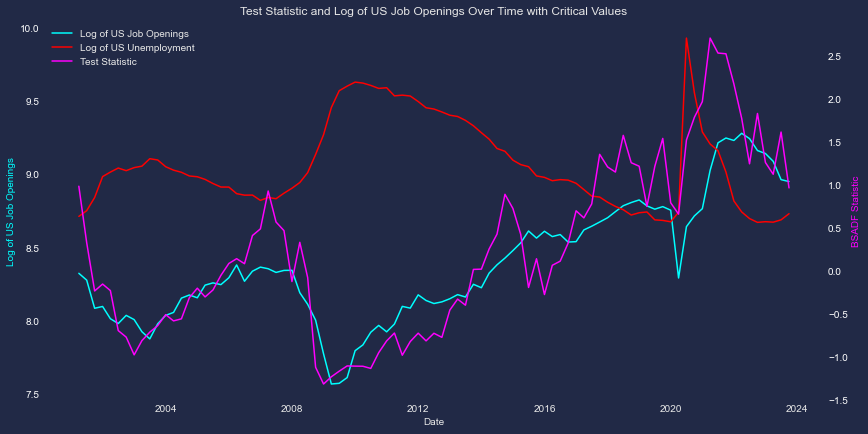

In [19]:

# Create the plot with specified figure size
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Get the current axes instance

# Plotting Job Openings on the left y-axis
ax1.plot(merged_df.index, merged_df['Log_USJO'], label='Log of US Job Openings', color=color_job_openings)
ax1.plot(merged_df.index, merged_df['Log_USU'], label='Log of US Unemployment', color=color_unemployment)

ax1.set_xlabel('Date')
ax1.set_ylabel('Log of US Job Openings', color=color_job_openings)
ax1.tick_params(axis='y', colors=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the BSADF Statistic data
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], label='Test Statistic', color=color_bsadf_stat)
ax2.set_ylabel('BSADF Statistic', color=color_bsadf_stat)
ax2.tick_params(axis='y', colors=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Title and legend handling
plt.title('Test Statistic and Log of US Job Openings Over Time with Critical Values')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust location as needed

# Save the plot to the specified directory and file
plt.savefig(f'{path}/Asset-Price-Bubble-Detection/results/{select}_Unemployment_Test_Stat.jpeg', format='jpeg')

# Show the plot
plt.show()


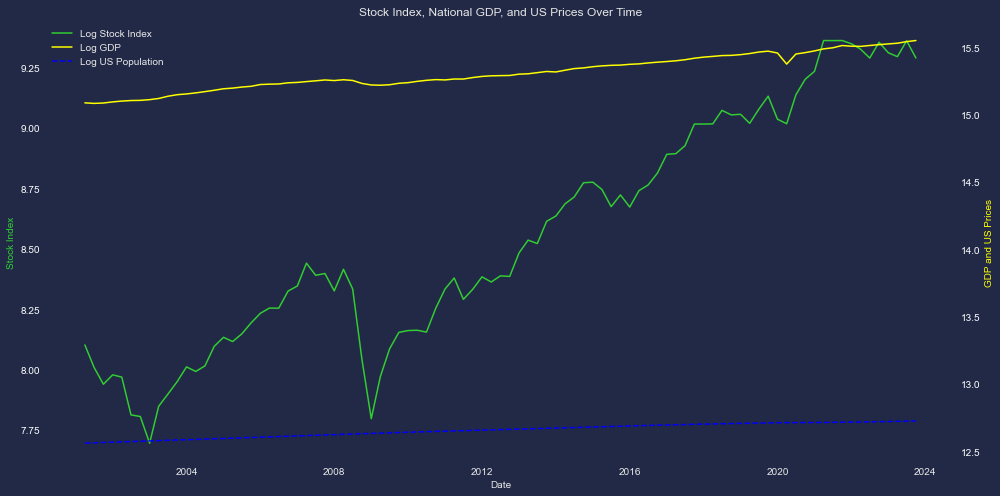

In [20]:
# Create a figure and a set of subplots with the desired size
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Price data on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index', color=color_stock_index)
ax1.plot(merged_df.index, merged_df['Log_Price'], color=color_stock_index, label='Log Stock Index')
ax1.tick_params(axis='y', labelcolor=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the GDP and US Prices data
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('GDP and US Prices', color=color_gdp)  # We already handled the x-label with ax1
ax2.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='Log GDP')
ax2.plot(merged_df.index, merged_df['Log_USP'], color=color_population, linestyle='--', label='Log US Population')  # Corrected label
ax2.tick_params(axis='y', labelcolor=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Title and layout
plt.title('Stock Index, National GDP, and US Prices Over Time')
fig.tight_layout()  # Otherwise the right y-label is slightly clipped

# Add legend to differentiate the data series
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust location as needed

# Save the plot to the specified directory and file
plt.savefig(f'{path}/Asset-Price-Bubble-Detection/results/{select}_Index_Price_GDP_USP.jpeg', format='jpeg')

# Show the plot
plt.show()


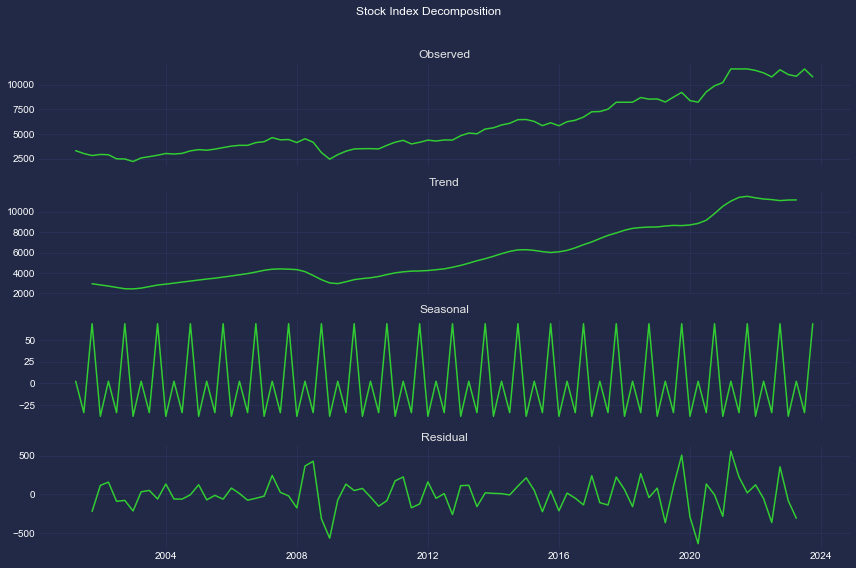

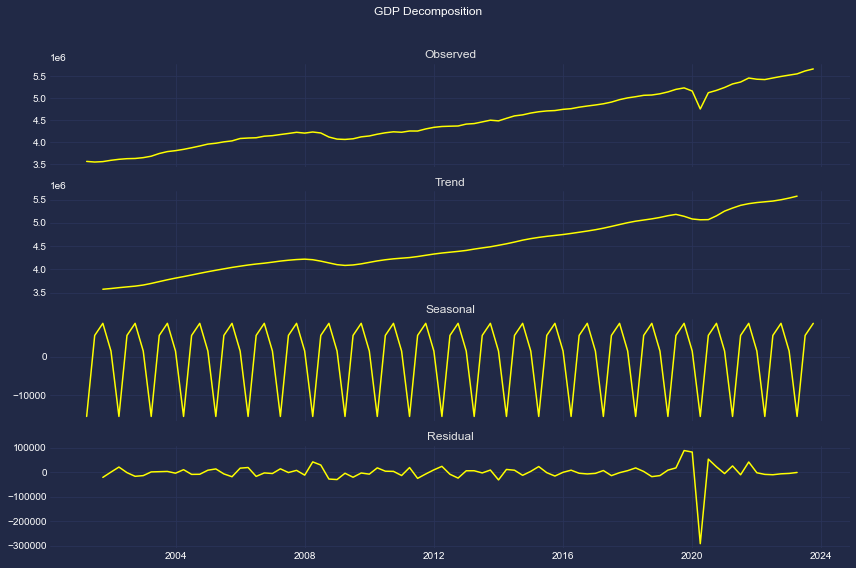

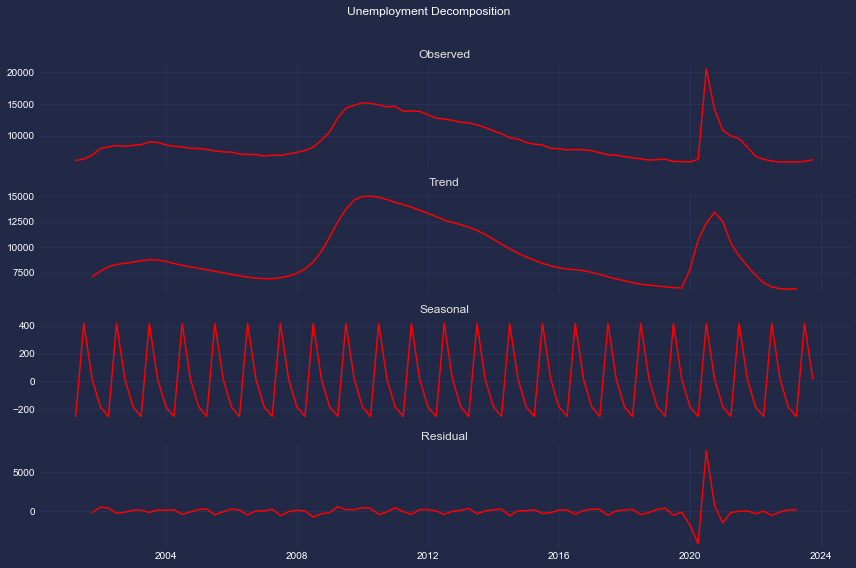

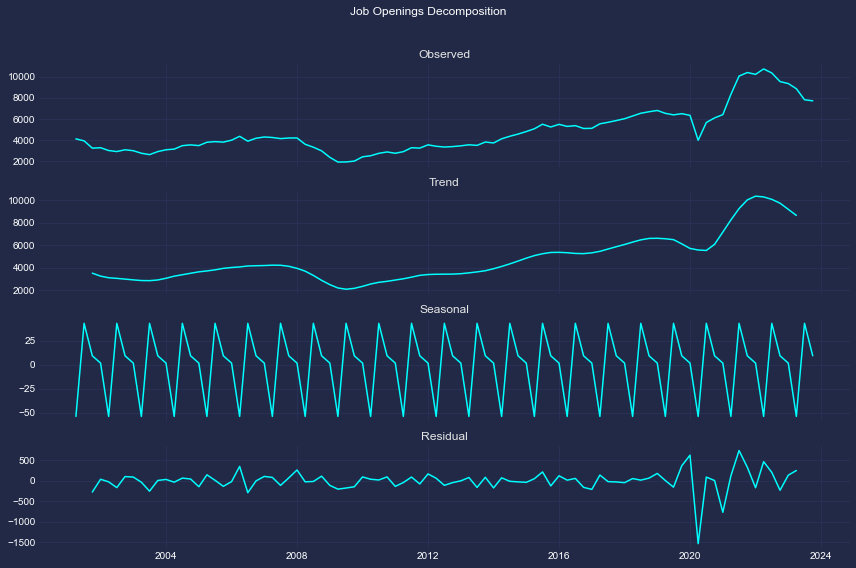

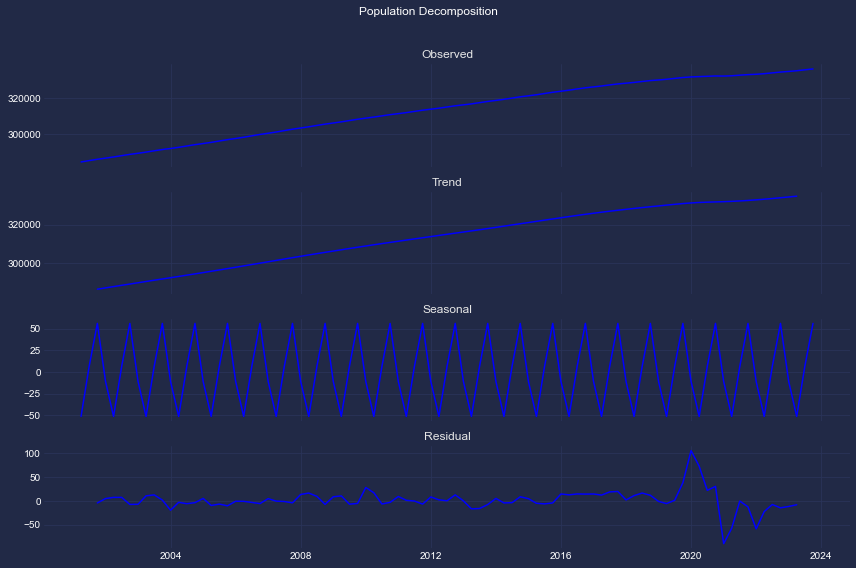

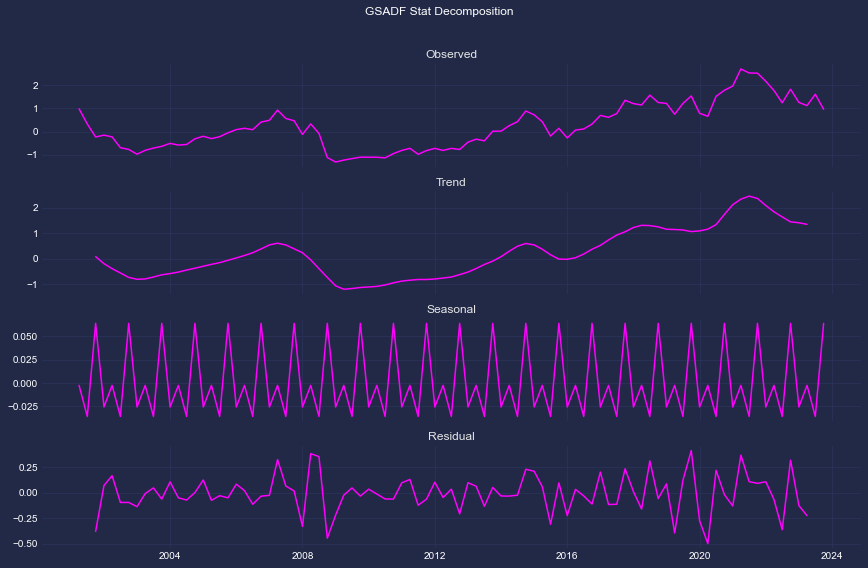

Index(['GDP', 'USE', 'USJO', 'USU', 'USP', 'Price', 'GSADF_Stat', 'Log_GDP',
       'GDP_Diff', 'Log_GDP_Diff', 'Log_Price', 'Price_Diff', 'Log_Price_Diff',
       'Log_USE', 'USE_Diff', 'Log_USE_Diff', 'Log_USJO', 'USJO_Diff',
       'Log_USJO_Diff', 'Log_USU', 'USU_Diff', 'Log_USU_Diff', 'Log_USP',
       'USP_Diff', 'Log_USP_Diff'],
      dtype='object')

In [21]:
# Customize plotting function
def customize_plot(result, title, color):
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))
    axes[0].plot(result.observed, color=color)
    axes[0].set_title('Observed')
    
    axes[1].plot(result.trend, color=color)
    axes[1].set_title('Trend')
    
    axes[2].plot(result.seasonal, color=color)
    axes[2].set_title('Seasonal')
    
    axes[3].plot(result.resid, color=color)
    axes[3].set_title('Residual')
    
    for ax in axes:
        ax.tick_params(axis='x', colors=axis_color)
        ax.tick_params(axis='y', colors=axis_color)

    plt.suptitle(title, color=axis_color)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    

# Applying the function to each series
# Decompose and plot Stock Index data
result_price = seasonal_decompose(merged_df['Price'], model='additive', period=4)  
customize_plot(result_price, 'Stock Index Decomposition', color_stock_index)

# Decompose and plot GDP data
result_gdp = seasonal_decompose(merged_df['GDP'], model='additive', period=4)  
customize_plot(result_gdp, 'GDP Decomposition', color_gdp)

# Decompose and plot Unemployment data
result_job_openings = seasonal_decompose(merged_df['USU'], model='additive', period=4)  
customize_plot(result_job_openings, 'Unemployment Decomposition', color_unemployment)
# Decompose and plot Job Openings data
result_job_openings = seasonal_decompose(merged_df['USJO'], model='additive', period=4)  
customize_plot(result_job_openings, 'Job Openings Decomposition', color_job_openings)

# Decompose and plot Population data
result_population = seasonal_decompose(merged_df['USP'], model='additive', period=4)  
customize_plot(result_population, 'Population Decomposition', color_population)
# Decompose and plot GSADF data
result_gsadf = seasonal_decompose(merged_df['GSADF_Stat'], model='additive', period=4)  
customize_plot(result_gsadf, 'GSADF Stat Decomposition', color_bsadf_stat)

merged_df.columns


## Vector Error Correction Model (VECM) with Explosive Unit Root, Job Openings, Stock Market Growth, and GDP

The Vector Error Correction Model (VECM) is a multivariate statistical model used to analyze the long-term and short-term dynamics among several non-stationary time series variables that are cointegrated. In this model, we include variables such as an explosive unit root, job openings, stock market growth, and GDP to understand their interdependencies and the adjustments toward equilibrium over time.

### Overview of the VECM

A VECM is particularly useful when dealing with non-stationary data series that exhibit a long-run equilibrium relationship, as suggested by cointegration tests. The inclusion of the error correction term allows the model to specify both the short-term dynamics and adjustments needed to return to equilibrium after shocks.

### Components of the Model

- **Explosive Unit Root:** This component typically represents a variable that shows persistent exponential growth or decline, diverging from a stable path. In financial data, this might be related to speculative bubbles or severe recessive movements.
- **Job Openings (USJO):** This measures the labor demand and is an indicator of economic health. Fluctuations in job openings can be both a cause and effect of economic cycles.
- **Stock Market Growth:** Often a leading indicator of economic health, as it reflects investor expectations about future corporate earnings and macroeconomic trends.
- **GDP (Gross Domestic Product):** Represents the total economic output and is a crucial measure of overall economic activity and health.

### Functioning of the VECM

In the VECM:
- The **long-term relationship** is captured by the cointegration among the variables, indicating that despite short-term fluctuations, the variables move together over time towards an equilibrium.
- The **short-term dynamics** are detailed by the coefficients of the lagged differences of the variables, indicating how each variable adjusts to changes in the others in the short term.
- The **error correction term** (ECT), derived from the deviation from the long-run equilibrium in the previous period, measures the speed and direction of adjustment back towards the equilibrium.

### Applications and Implications

This model can be particularly insightful for policymakers and investors as it provides:
- Insights into how quickly economic variables return to stability after a shock, which is crucial for monetary and fiscal policy decisions.
- Understanding the impact of stock market fluctuations and job market dynamics on overall economic growth.
- Early warnings of economic overheating or underperformance through the explosive unit root component, guiding preemptive actions.

By analyzing the interactions and adjustments between these critical economic indicators, a VECM helps in predicting future economic conditions and designing informed economic policies.


In [84]:
# Fit the model
# Determine the optimal lag order
data = merged_df[['Log_Price', 'Log_GDP', 'Log_USJO','Log_USU','GSADF_Stat','Log_USP']]

lag_order = select_order(data=data, maxlags=20, deterministic="ci")
print(lag_order.summary())
optimal_lags = lag_order.fpe
#override 
optimal_lags =  8
optimal_lags

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -43.41      -41.87   1.416e-19      -42.79
1       -45.22      -42.52   2.384e-20      -44.14
2       -45.73      -41.87   1.528e-20      -44.19
3       -46.55      -41.54   7.605e-21      -44.56
4       -47.06      -40.89   5.645e-21      -44.61
5       -47.73      -40.41   4.088e-21      -44.82
6       -48.07      -39.59   5.026e-21      -44.70
7       -49.68      -40.04   2.347e-21      -45.85
8       -52.27      -41.47   7.190e-22      -47.98
9       -57.80      -45.85   3.850e-23      -53.06
10      -102.4      -89.31   3.093e-39      -97.21
11      -308.8      -294.5  5.321e-131      -303.1
12      -321.1      -305.6  4.618e-139      -314.9
13      -338.7      -322.1  2.818e-148      -332.1
14      -351.3      -333.5  6.395e-155      -344.2
15      -353.9      -335.0  4.639e-157      -346.4
16      -358.5     -338.4*  6.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

8

In [85]:
# Perform the Johansen cointegration test
data = merged_df[['Log_Price', 'Log_GDP', 'Log_USJO','Log_USU','GSADF_Stat','Log_USP']]

result = coint_johansen(data, det_order=0, k_ar_diff= optimal_lags)

# Print the Trace Statistics and Critical Values
print('Trace Statistics:', result.lr1)
print('Critical Values (90%, 95%, 99%):', result.cvt)

# Interpret and print whether cointegration is found
cointegration_found = False  # A flag to keep track of cointegration status
for i, trace_stat in enumerate(result.lr1):
    if trace_stat > result.cvt[i][0]:  # Index 1 is for the 95% confidence level
        cointegration_found = True
        print(f"At the 90% confidence level, we reject the null hypothesis of at most {i} cointegrating relations; indicating cointegration.")
    else:
        print(f"At the 90% confidence level, we fail to reject the null hypothesis of at most {i} cointegrating relations; no cointegration indicated.")

# Print overall result based on tests
if cointegration_found:
    print("The series exhibit a long-run cointegrating relationship.")
else:
    print("No long-run cointegrating relationship is evident among the series.")


Trace Statistics: [213.45607959 126.07887777  69.33696111  39.61201905  15.96090683
   1.24377728]
Critical Values (90%, 95%, 99%): [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
At the 90% confidence level, we reject the null hypothesis of at most 0 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 1 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 2 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 3 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 4 cointegrating relations; indicating cointegration.
At the 90% confidence level, we fail to reject the null hypothesis of at

In [86]:
rank_test = select_coint_rank(data, 1, optimal_lags, method="trace",
                              signif=0.10)
rank_test.summary()


r_0,r_1,test statistic,critical value
0,6,244.4,102.5
1,6,168.6,75.10
2,6,99.52,51.65
3,6,46.08,32.06
4,6,17.37,16.16
5,6,3.185,2.705


## Understanding the Results of the `select_rank` Function

The `select_rank` function is an essential tool in time series analysis, especially when setting up a Vector Error Correction Model (VECM). This function helps in determining the number of cointegrating relationships among a set of non-stationary variables. Here's a breakdown of what the results mean and how they are interpreted:

### Purpose of `select_rank`

- **Identify Cointegration Rank:** The main purpose of the `select_rank` function is to identify the rank of cointegration among the variables in a given dataset. The cointegration rank specifies the number of linearly independent vectors that combine the integrated variables into stationary processes.

### How It Works

- **Test Setup:** The function typically utilizes tests like the Johansen cointegration test, which examines the null hypothesis of `r` cointegrating relationships against the alternative of more cointegrating vectors up to the number of included variables.
- **Statistical Methods:** It involves methods such as trace statistics and maximum eigenvalue statistics, which help in determining the presence and number of cointegrating relationships.

### Results Interpretation

1. **Number of Cointegrating Vectors (Rank)**
   - The function outputs the estimated number of cointegrating relationships. This number tells us how many independent long-term relationships exist among the variables.
   - **Example:** If `select_rank` returns a cointegration rank of 2 for a system of 5 variables, it implies there are two unique long-term equilibrium relationships binding these variables together.

2. **Statistical Values**
   - **Trace Statistic and Maximum Eigenvalue:** These are the key outputs used to determine the cointegration rank. Each statistic tests for additional cointegrating vectors.
   - The results typically include critical values or p-values, which help in deciding whether to reject the null hypothesis of `r` cointegrating vectors.

3. **Model Specification**
   - Based on the rank, the error correction terms in the VECM are specified. Each cointegrating relationship will contribute one error correction term to the model, guiding how quickly variables adjust to restore equilibrium after a shock.



In [87]:
# Configure and fit the VECM model
vecm_model = VECM(data, k_ar_diff= optimal_lags, coint_rank=5, deterministic= 'ci')
vecm_result = vecm_model.fit()
vecm_result.summary()


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
L1.Log_Price,0.8647,0.528,1.638,0.101,-0.170,1.899
L1.Log_GDP,1.0227,1.321,0.774,0.439,-1.567,3.612
L1.Log_USJO,-0.3455,0.268,-1.291,0.197,-0.870,0.179
L1.Log_USU,0.1038,0.232,0.448,0.654,-0.350,0.558
L1.GSADF_Stat,0.0455,0.080,0.570,0.569,-0.111,0.202
L1.Log_USP,89.8713,94.033,0.956,0.339,-94.430,274.172
L2.Log_Price,0.6368,0.453,1.407,0.159,-0.250,1.524
L2.Log_GDP,-4.8162,2.287,-2.106,0.035,-9.299,-0.334
L2.Log_USJO,-0.0317,0.240,-0.132,0.895,-0.502,0.439
L2.Log_USU,0.3097,0.204,1.520,0.128,-0.090,0.709


Plotting GDP and Stock Market Predictions

array([[ 9.18280727, 15.52887306,  8.69740739,  8.56701519,  0.84781129,
        12.72581169],
       [ 9.02146984, 15.52040173,  8.51100622,  8.8306398 ,  0.46689642,
        12.72712192],
       [ 8.87883699, 15.49983582,  8.26827876,  8.9775649 ,  0.12506952,
        12.72874432],
       ...,
       [10.0000842 , 15.75411548,  9.1251989 ,  9.34061953,  1.94744001,
        12.83028554],
       [ 9.97170984, 15.75251341,  9.080367  ,  9.40482287,  1.82798595,
        12.83017844],
       [ 9.93964318, 15.74936189,  9.02982008,  9.44610843,  1.678974  ,
        12.83003889]])

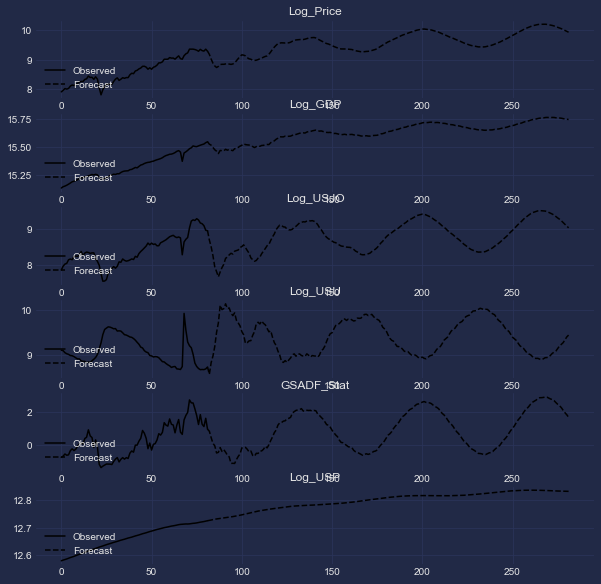

In [88]:
num_periods = 200

vecm_result.plot_forecast(steps=num_periods, plot_conf_int=False)
forecast_df = vecm_result.predict(steps=num_periods)
forecast_df

## Understanding Impulse Response Function (IRF) Plots from VECM

Impulse Response Function (IRF) plots are a crucial tool in time series analysis, particularly when using Vector Error Correction Models (VECM) to understand the dynamic interactions between variables. These plots illustrate how a shock to one variable affects other variables in the system over time. Here’s an explanation of how to interpret these plots and understand their implications.

### What are IRF Plots?

- **Definition:** IRF plots show the reaction of dependent variables in a VECM to one-time shocks in each of the other variables. They help in visualizing the time path of these effects and the gradual adjustment of the variables towards equilibrium.
- **Purpose:** The primary purpose of generating IRF plots in a VECM framework is to analyze the effect of changes (or shocks) in one variable on the entire system over a specified number of periods.

### Generating IRF Plots

- **Procedure:** In the provided code snippet, the impulse response function is computed for a given number of periods (`num_periods = 200`). This function simulates the response of all endogenous variables in the model to a shock in each variable, one at a time.
- **Visualization:** The method `ir.plot(plot_stderr=False)` generates a series of line plots. Each plot represents the response of one variable to a unit shock in each of the other variables, including itself, over the 200 periods.
- **File Saving:** The plots are then saved as JPEG images in a specified directory, allowing for further analysis or presentation.

### Interpretation of IRF Plots

1. **Response Over Time:**
   - Each line on the plot shows how a particular variable reacts over time after the shock. The x-axis represents time in periods after the shock, and the y-axis shows the magnitude of the variable's response.
   - Positive values indicate an increase in the variable relative to its baseline value due to the shock, while negative values indicate a decrease.

2. **Speed and Magnitude of Adjustment:**
   - The plots provide insights into how quickly and significantly variables adjust in response to shocks. Rapid declines or increases followed by stabilization suggest quick adjustments to shocks.
   - Large swings or sustained deviations from zero can indicate high sensitivity to shocks and potentially longer-term impacts on the variable.

3. **Economic Implications:**
   - By observing the IRF plots, analysts can infer the stability and resilience of the economic system or market under study. For example, a prolonged or significant response in GDP or stock prices to a policy change or economic event might signal underlying vulnerabilities or strong dependencies.


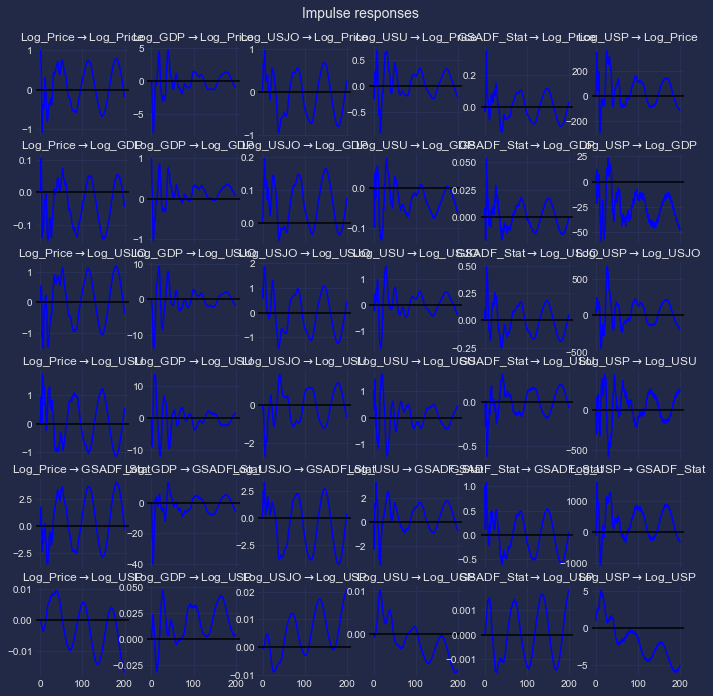

In [89]:
ir = vecm_result.irf(periods=num_periods)
ir.plot(plot_stderr=False)
filename = f'{ticker}_irf.jpg'
plt.savefig(f'{path}/Asset-Price-Bubble-Detection//results/{select} IRF.jpeg', format='jpeg')



Forecast Level Calculation:

add the forecasted differences back to the last observed level, making the output interpretable in the original data's context.

In [90]:
# Define color variables
color_job_openings = 'cyan'
color_bsadf_stat = 'magenta'
color_stock_index = 'limegreen'
color_gdp = 'yellow'
color_population = 'blue'
color_unemployment = 'red'
axis_color = 'white' 

In [91]:

# Last observed level data
last_gdp = merged_df['Log_GDP'].iloc[-1]
last_price = merged_df['Log_Price'].iloc[-1]

# Forecast of differenced data
forecast_USP = forecast_df[:, 5]
forecast_USU = forecast_df[:, 3]
forecast_USJO = forecast_df[:, 2]
forecast_adf = forecast_df[:, 4]
forecast_gdp = forecast_df[:, 1]
forecast_price = forecast_df[:, 0]


# Get the last date in price_df.index
last_date = merged_df.index[-1]

# Add one quarter to the last date
forecast_date = last_date + relativedelta(months=+3)

# Create forecast_dates using pd.date_range
forecast_dates = pd.date_range(start=forecast_date, periods=len(forecast_df), freq='Q')
forecast_df = pd.DataFrame({
    'Log_Price': forecast_price,
    'Log_GDP': forecast_gdp,
    'GSADF_Stat': forecast_adf,
    'Log_USJO': forecast_USJO,
    'Log_USU': forecast_USU,
    'Log_USP': forecast_USP
}, index=forecast_dates)

forecast_df

,Log_Price,Log_GDP,GSADF_Stat,Log_USJO,Log_USU,Log_USP
2024-03-31,9.182807,15.528873,0.847811,8.697407,8.567015,12.725812
2024-06-30,9.021470,15.520402,0.466896,8.511006,8.830640,12.727122
2024-09-30,8.878837,15.499836,0.125070,8.268279,8.977565,12.728744
2024-12-31,8.785993,15.478973,-0.019066,7.961236,9.190512,12.730061
2025-03-31,8.732558,15.466360,-0.447562,7.831445,9.506849,12.731039
...,...,...,...,...,...,...
2072-12-31,10.060497,15.761228,2.248695,9.223268,9.239542,12.830811
2073-03-31,10.029832,15.757251,2.091777,9.173466,9.277930,12.830505
2073-06-30,10.000084,15.754115,1.947440,9.125199,9.340620,12.830286
2073-09-30,9.971710,15.752513,1.827986,9.080367,9.404823,12.830178


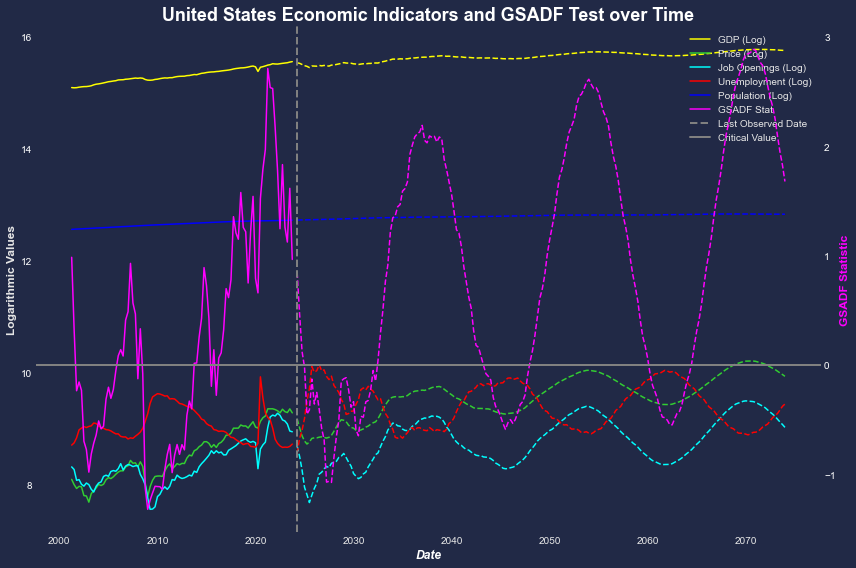

In [93]:
# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))


# Plotting all logarithmic data on the primary left y-axis
ax1.set_xlabel('Date', style='italic', color=axis_color, fontsize=12, fontweight='bold')
ax1.set_ylabel('Logarithmic Values', fontsize=12, fontweight='bold')
ax1.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='GDP (Log)')
ax1.plot(merged_df.index, merged_df['Log_Price'], color=color_stock_index, label='Price (Log)')
ax1.plot(merged_df.index, merged_df['Log_USJO'], color=color_job_openings, label='Job Openings (Log)')
ax1.plot(merged_df.index, merged_df['Log_USU'], color=color_unemployment, label='Unemployment (Log)')
ax1.plot(merged_df.index, merged_df['Log_USP'], color=color_population, label='Population (Log)')  # New population line

# Optional: Forecast data plotting
ax1.plot(forecast_df.index, forecast_df['Log_GDP'], linestyle='--', color=color_gdp, label='GDP (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_Price'], linestyle='--', color=color_stock_index, label='Price (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USJO'], linestyle='--', color=color_job_openings, label='Job Openings (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USU'], linestyle='--', color=color_unemployment, label='Unemployment (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USP'], linestyle='--', color=color_population, label='Population (Log)') 

ax1.tick_params(axis='y', labelcolor=axis_color, labelsize=10)
ax1.grid(False)  # Disable gridlines for this axis

# Create a second y-axis for the GSADF Statistic data
ax2 = ax1.twinx()
ax2.set_ylabel('GSADF Statistic', color=color_bsadf_stat, fontsize=12, fontweight='bold')
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], color=color_bsadf_stat, label='GSADF Stat')
ax2.plot(forecast_df.index, forecast_df['GSADF_Stat'], linestyle='--', color=color_bsadf_stat, label='GSADF Stat')
ax2.tick_params(axis='y', labelcolor=axis_color, labelsize=10)
ax2.grid(False)  # Disable gridlines for this axis

# Adding a vertical line for the last observed date
last_observed_date = forecast_df.index[0]  # Assuming forecast_df.index contains the dates
plt.axvline(x=last_observed_date, color='gray', linestyle='--', linewidth=2, label='Last Observed Date')

ax2.axhline(y=critical_values[0], color='gray', linestyle='-', linewidth=2, label='Critical Value')

# Title and legend handling
plt.title(f'{select} Economic Indicators and GSADF Test over Time', color=axis_color, fontsize=18, fontweight='bold')
fig.tight_layout()

# Collecting handles and labels from both axes for a unified legend, avoiding duplicates
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)
ax1.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))

# Save and show the plot
plt.savefig(f'{path}/Asset-Price-Bubble-Detection/results/{select}_Final_Model.jpeg', format='jpeg')
plt.show()


In [94]:
merged_df = pd.concat([merged_df, forecast_df])
T = len(merged_df)

merged_df

,GDP,USE,USJO,USU,USP,Price,GSADF_Stat,Log_GDP,GDP_Diff,Log_GDP_Diff,...,Log_USE_Diff,Log_USJO,USJO_Diff,Log_USJO_Diff,Log_USU,USU_Diff,Log_USU_Diff,Log_USP,USP_Diff,Log_USP_Diff
2001-04-01,3567923.5,136719.3333,4125.0,6084.0,284838.0,3302.189941,0.986011,15.087494,22143.5,0.006226,...,-0.002693,8.324821,-627.0,-0.141500,8.713418,481.0,0.082360,12.559676,669.0,0.002351
2001-07-01,3553629.0,136225.6667,3937.0,6327.0,285584.0,3009.209961,0.328150,15.083480,-14294.5,-0.004014,...,-0.003617,8.278174,-188.0,-0.046647,8.752581,243.0,0.039164,12.562291,746.0,0.002616
2001-10-01,3563393.5,136105.3333,3249.0,6922.0,286311.0,2807.510010,-0.233647,15.086224,9764.5,0.002744,...,-0.000884,8.086103,-688.0,-0.192072,8.842460,595.0,0.089879,12.564834,727.0,0.002542
2002-01-01,3593196.3,136360.0000,3289.0,7985.0,286935.0,2918.530029,-0.153319,15.094553,29802.8,0.008329,...,0.001869,8.098339,40.0,0.012236,8.985320,1063.0,0.142860,12.567011,624.0,0.002177
2002-04-01,3615212.0,136806.6667,3025.0,8234.0,287574.0,2891.060059,-0.229383,15.100661,22015.7,0.006108,...,0.003270,8.014666,-264.0,-0.083672,9.016027,249.0,0.030707,12.569235,639.0,0.002225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072-12-31,NaN,NaN,NaN,NaN,NaN,NaN,2.248695,15.761228,NaN,NaN,...,NaN,9.223268,NaN,NaN,9.239542,NaN,NaN,12.830811,NaN,NaN
2073-03-31,NaN,NaN,NaN,NaN,NaN,NaN,2.091777,15.757251,NaN,NaN,...,NaN,9.173466,NaN,NaN,9.277930,NaN,NaN,12.830505,NaN,NaN
2073-06-30,NaN,NaN,NaN,NaN,NaN,NaN,1.947440,15.754115,NaN,NaN,...,NaN,9.125199,NaN,NaN,9.340620,NaN,NaN,12.830286,NaN,NaN
2073-09-30,NaN,NaN,NaN,NaN,NaN,NaN,1.827986,15.752513,NaN,NaN,...,NaN,9.080367,NaN,NaN,9.404823,NaN,NaN,12.830178,NaN,NaN


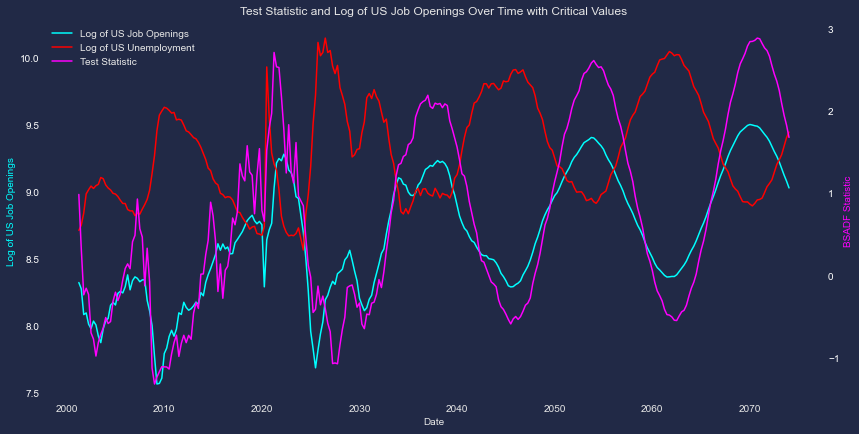

In [95]:
# Create the plot with specified figure size
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Get the current axes instance

# Plotting Job Openings on the left y-axis
ax1.plot(merged_df.index, merged_df['Log_USJO'], label='Log of US Job Openings', color=color_job_openings)
ax1.plot(merged_df.index, merged_df['Log_USU'], label='Log of US Unemployment', color=color_unemployment)

ax1.set_xlabel('Date')
ax1.set_ylabel('Log of US Job Openings', color=color_job_openings)
ax1.tick_params(axis='y', colors=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the BSADF Statistic data
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], label='Test Statistic', color=color_bsadf_stat)
ax2.set_ylabel('BSADF Statistic', color=color_bsadf_stat)
ax2.tick_params(axis='y', colors=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis


# Title and legend handling
plt.title('Test Statistic and Log of US Job Openings Over Time with Critical Values')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust location as needed

# Save the plot to the specified directory and file
plt.savefig(f'{path}/Asset-Price-Bubble-Detection/results/{select}_Unemployment_Test_Stat_F.jpeg', format='jpeg')

# Show the plot
plt.show()


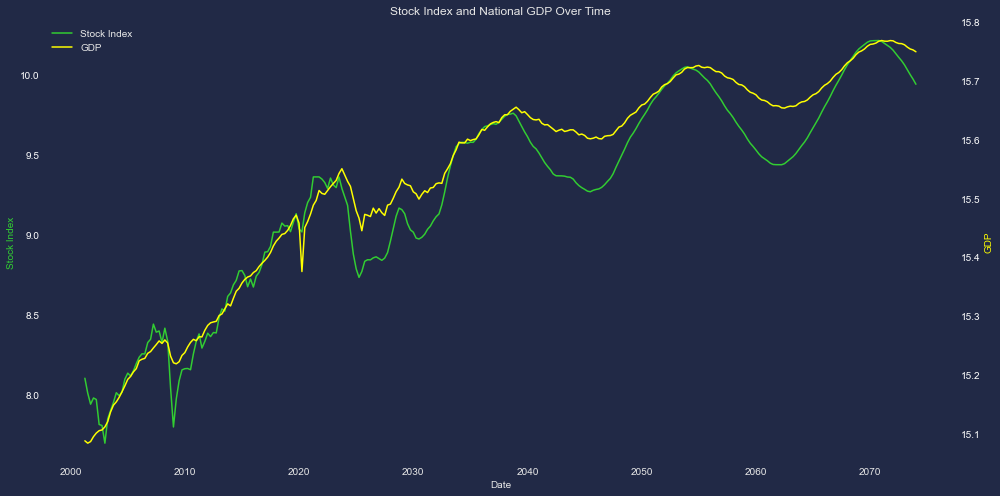

In [97]:
# Create a figure and a set of subplots with the desired size

# Create a figure and a set of subplots with the desired size
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Price data on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index', color=color_stock_index)
line1, = ax1.plot(merged_df.index, merged_df['Log_Price'], color=color_stock_index, label='Stock Index')
ax1.tick_params(axis='y', labelcolor=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('GDP', color=color_gdp)  # We already handled the x-label with ax1
line2, = ax2.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='GDP')
ax2.tick_params(axis='y', labelcolor=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Title and layout
plt.title('Stock Index and National GDP Over Time')
fig.tight_layout()  # Otherwise the right y-label is slightly clipped

# Add a legend to the plot
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')


# Save the plot to the specified directory and file
plt.savefig(f'{path}/Asset-Price-Bubble-Detection/results/{select}_Index_Price_GDP_F.jpeg', format='jpeg')

# Show the plot
plt.show()
